# Install packages and write functions

In [ ]:
import os
import pandas as pd
import transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)  # Add count of files in this directory
    return total_files

/Users/she4/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def extract_abstract(pubtator_file):
    abstract_text = ""
    with open(pubtator_file, 'r', encoding='utf-8') as file:  
        for line in file:
            parts = line.strip().split('|')
            if len(parts) == 3 and parts[1].strip() == 'a':  
                abstract_text = parts[2].strip()
                break  
    return abstract_text

def align_predictions(predictions, label_list,tokenizer):
    entities = []
    for idx, pred in enumerate(predictions[0]):
        label = label_list[pred.item()]
        entities.append((tokenizer.decode(tokenized_input["input_ids"][0][idx]), label))
    return entities

def process_entities(named_entities):
    processed_entities = []
    current_entity = ""
    for token, tag in named_entities:
        if tag.startswith('B'):
            if current_entity:  # Save previous entity if exists
                processed_entities.append(current_entity.strip())
            current_entity = token.replace('##', '')
        else:
            if token in ['-', '(', ')']: # Special handling for hyphens and parentheses
                current_entity += token
            elif token.startswith('##'):
                current_entity += token.replace('##', '') # For token continuations (indicated by "##"), append without a leading space
            else:
                current_entity += ' ' + token.replace('##', '')
    if current_entity:
        processed_entities.append(current_entity.strip())
    return processed_entities

def extract_entities(pubtator_file):
    entities = []
    with open(pubtator_file, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) >= 5 and parts[0].isdigit():  
                entity_info = {
                    'PMID': parts[0],
                    'OffsetStart': parts[1],
                    'OffsetEnd': parts[2],
                    'Entity': parts[3],
                    'Text': parts[4],
                    'Metadata': parts[5] if len(parts) > 5 else None
                }
                entities.append(entity_info)
    return entities

def has_exact_match(term,original_text):
    pattern = r'\b' + re.escape(term.lower()) + r'\b'
    return bool(re.search(pattern, original_text.lower()))

In [ ]:
import csv
import re
import fitz
from groq import Groq
import os
import itertools

client = Groq(api_key='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')
def generate_prompts_disease(potential_disease):
    system_prompt = """
    You are a doctor with expertise in disease naming conventions. 
    """
    user_prompt = f"""
    I have these terms, {potential_disease}, 
    can you shorten the list to retain the most informative disease terms only. 
    Please only output the term?
    """
    return system_prompt, user_prompt

import time
def get_response_disease(potential_pathways):
    retry_count = 0
    max_retries = 3  # adjust the number of retries as needed
    delay = 300  # 5 minutes in seconds

    while retry_count < max_retries:
        try:
            system_prompt, user_prompt = generate_prompts_disease(potential_pathways)
            response = client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": system_prompt,
                    },
                    {
                        "role": "user",
                        "content": user_prompt,
                    }
                ],
                model="llama3-groq-70b-8192-tool-use-preview",
                max_tokens=8192,
                temperature=0
            )
            return response.choices[0].message.content
        except Exception as e:
            if "503" in str(e) or "internal_server_error" in str(e):
                print(f"Retry {retry_count+1}: {e}")
                time.sleep(delay)
                retry_count += 1
            else:
                raise

    raise Exception("Maximum retries exceeded")

In [ ]:
import spacy
import re
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
def extract_pathways(sentences):
    nlp = spacy.load("en_core_web_sm")
    pathways = set()

    for sentence in sentences:
        doc = nlp(sentence)
        
        for chunk in doc.noun_chunks:
            # Check if the chunk has more than one token and doesn't contain stop words
            if len(chunk) > 1 and not any(token.is_stop for token in chunk):
                pathways.add(chunk.text) # Add the noun phrase to the pathways set

    return list(pathways)
def split_into_sentences(paragraph):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', paragraph)
    return sentences

import requests
from urllib.parse import quote_plus
import Levenshtein
import re

API_KEY = "3647522e-2c72-45f7-a0bf-79b7602223aa"
BASE_URL = "https://uts-ws.nlm.nih.gov/rest"

def query_umls(term):
    encoded_term = quote_plus(term)
    url = f"{BASE_URL}/search/current?string={encoded_term}&apiKey={API_KEY}"
    
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['result']['results']
    else:
        print(f"Error querying UMLS for term '{term}': {response.status_code}")
        return []

def is_similar_term(term1, term2, threshold=0.8):
    term1 = ' '.join(term1.lower().split()) # lowercase
    term2 = ' '.join(term2.lower().split())
    
    ratio = Levenshtein.ratio(term1, term2) # Calculate Levenshtein ratio
    return ratio >= threshold

def is_biomedical_term(term,threshold=0.90):
    results = query_umls(term)
    
    if results:
        return any(is_similar_term(term, result['name'], threshold) for result in results) # Check if any result is similar to our term
    words = term.split()
    return any(query_umls(word) for word in words if len(word) > 2)

def filter_biomedical_terms(entities):
    biomedical_terms = []
    removed_terms = []
    
    for term in entities:
        if is_biomedical_term(term):
            biomedical_terms.append(term)
        else:
            removed_terms.append(term)
    
    return biomedical_terms, removed_terms

def is_likely_biology_term(term):
    term_lower = term.lower() # lowercase
    words = term_lower.split()
    
    # Check for terms with specific characteristics common in biology
    
    if re.search(r'\d', term) or re.search(r'alpha|beta|gamma|delta', term_lower):  # Terms with numbers or Greek letters
        return True
    
    if '-' in term or '/' in term:  # Terms with hyphens or slashes
        return True
    
    if re.search(r'\b[A-Z]{2,}\b', term): # Terms with uppercase letters (potential acronyms)
        return True
    
    if len(words) >= 4: # Longer terms (4 or more words) are more likely to be specific
        return True
    
    biology_suffixes = ['ase', 'in', 'ion', 'itis', 'osis', 'oma', 'icity', 'pathy'] # Terms ending with specific suffixes common in biology
    if any(word.endswith(tuple(biology_suffixes)) for word in words):
        return True
    
    biology_substrings = ['cell', 'gene', 'protein', 'receptor', 'antibody', 'immune', 'tumor', 'cancer', 'virus', 'bacteria']
    if any(substring in term_lower for substring in biology_substrings):
        return True
    
    return False

def clean_terms(terms, original_text):
    original_text_lower = original_text.lower()
    
    def has_exact_match(term):
        pattern = r'\b' + re.escape(term.lower()) + r'\b'
        return bool(re.search(pattern, original_text_lower))
    

    filtered_terms = [term for term in terms if has_exact_match(term) and is_likely_biology_term(term)]
    sorted_terms = sorted(filtered_terms, key=len, reverse=True)
    cleaned_terms = []

    for i, term in enumerate(sorted_terms):
        is_substring = False
        for j, longer_term in enumerate(sorted_terms):
            if i != j and term.lower() in longer_term.lower():
                is_substring = True
                break
        if not is_substring:
            cleaned_terms.append(term)

    return cleaned_terms

def remove_genes(processed_gene, cleaned_terms): # remove terms if it is already present in extracted genes

    processed_gene_lower = set(word.lower() for word in processed_gene)
    def should_keep_term(term):
        term_lower = term.lower()
        for gene in processed_gene_lower:
            if gene in term_lower:
                return False
        return True
    result = [term for term in cleaned_terms if should_keep_term(term)]
    return result

import string
def filter_entities(entities):
    def should_keep(entity):
        digit_count = sum(c.isdigit() for c in entity)
        has_punctuation = any(c in string.punctuation for c in entity)
        return digit_count < 3 and not has_punctuation
    
    return [entity for entity in entities if should_keep(entity)]

def filter_entities(entities):
    return [entity for entity in entities if '(' not in entity and ')' not in entity]

import csv
import re
import fitz
from groq import Groq
import os
import itertools

client = Groq(api_key='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')

def generate_prompts_pathway(potential_pathways):
    system_prompt = """
    You are a computational biologist with expertise in biomedical pathways. 
    Your task is to identify genuine biomedical pathways from a given list of terms. 
    Use your knowledge to filter out non-pathway terms based on the following criteria:

    1. Exclude laboratory techniques, methods, or procedures (e.g., assays).
    2. Exclude terms that are too general (e.g., "gene expression", "transcription activity", "transcriptional activation",'regulation').
    3. Exclude cell types, cell lines, or cell clones.

    Provide only the terms that represent valid biomedical pathways. Double-check your output to ensure all terms meet the criteria.
    """

    user_prompt = f"""
    I've provided these terms: {potential_pathways}.
    Please identify which of these are likely biomedical pathways, excluding any that don't meet the criteria specified in your instructions.
    Output only the valid pathway terms (in a list) with no additional explanation.
    """

    return system_prompt, user_prompt

def get_response_pathway(potential_pathways):
    system_prompt, user_prompt = generate_prompts_pathway(potential_pathways)
    
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ],
        model="llama3-groq-70b-8192-tool-use-preview",
        max_tokens=8192,
        temperature=0
    )
    return response.choices[0].message.content

In [5]:
import csv
import re
import fitz
from groq import Groq
import os
import itertools

# Initialize the Groq API client
client = Groq(api_key='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')
def generate_prompt_finalize(entities):
    system_prompt = f"""
    I have these terms that the algorithm has extracted as potential biologically relevant entities from an abstract.
    As a biologist, can you please help me remove and combine terms and output only the informative terms?
    """
    user_prompt = f"""
    Potential biomedically relevant terms: {', '.join(entities)}
    Please output only the informative terms in a list! no extra explanation
    """
    return system_prompt, user_prompt

def get_response_finalize(entities):
    system_prompt, user_prompt = generate_prompt_finalize(entities)
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ],
        model="llama3-groq-70b-8192-tool-use-preview",
        max_tokens=8192,
        temperature=0
    )
    return response.choices[0].message.content

In [ ]:
import itertools
from groq import Groq
import time

relationship_client = Groq(api_key='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')

def generate_prompt_relationship(abstract, entity_pairs):
    system_prompt = """
    You are a computational biologist who excels at carefully reading biomedical publication abstracts and inferring the relationship between
    biomedical terms based on the abstract's content.
    """
    user_prompt = f"""
    I will provide you with an Abstract and multiple pairs of Biomedical terms.
    Abstract: {abstract}

    For each pair of terms, determine if there is a directional relationship from the first term to the second term.
    The relationship should be one of the following three options:
    - 'Inhibit' if the first term directly or indirectly reduces, blocks, or inhibits the second term.
    - 'Activate' if the first term directly or indirectly promotes or leads to the second term.
    - 'no association' if there is no clear direct or indirect relationship from the first term to the second term, or if you are unsure about the relationship based on the provided information.

    Important rules to follow:
    - The relationship must be inferred in the direction from the first term to the second term only. Do not infer relationships in the opposite direction unless explicitly stated in the sentence.
    - If the relationship is ambiguous or unclear in the abstract, choose 'no association.'
    - If either term lacks a clear biological meaning in the context of the abstract, output 'no association.'
    - After determining the relationship, validate the answer by re-reading the abstract. If you cannot confidently validate the direction of the relationship, then change your output to 'no association'.

    Biomedical term pairs:
    {', '.join([f'({pair[0]}, {pair[1]})' for pair in entity_pairs])}

    **Remember:**
    - If term1 inhibits term2, the output should be (term1, term2, Inhibit).
    - If term1 activates term2, the output should be (term1, term2, Activate).
    - If term1 does not affect term2 or you cannot validate it, output (term1, term2, no association).
    - If term2 does not directly or indirectly affect term1, the output should always be (term2, term1, no association).
    Output your response in the following format: ('term1', 'term2', relationship) and this format only.
    Examples:
    - "TNF-α stimulates NF-κB activity, resulting in increased expression of proinflammatory genes."
       - If term1 is TNF-α and term2 is NF-κB, the output is (TNF-α, NF-κB, Activate).
       - If term1 is NF-κB and term2 is TNF-α, the output is (NF-κB, TNF-α, no association).
    - "PD-1 signaling inhibits T cell activation, leading to immune evasion by tumor cells."
       - If term1 is PD-1 and term2 is T cell activation, the output is (PD-1, T cell activation, Inhibit).
       - If term1 is T cell activation and term2 is PD-1, the output is (T cell activation, PD-1, no association).

    Output your response in the following format for each pair:
    (term1, term2, relationship)

    Provide your answer as a comma-separated list of these tuples, one for each input pair.
    Only include pairs where the relationship is either 'Activate' or 'Inhibit'.
    """
    return system_prompt, user_prompt

def get_relationships(abstract, entities):
    pairs = list(itertools.permutations(entities, 2))
    
    system_prompt, user_prompt = generate_prompt_relationship(abstract, pairs)
    
    max_retries = 3
    retry_count = 0
    
    while retry_count < max_retries:
        try:
            response = relationship_client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": system_prompt,
                    },
                    {
                        "role": "user",
                        "content": user_prompt,
                    }
                ],
                model="llama3-70b-8192", # llama-3.1-70b-versatile,llama3-70b-8192
                max_tokens=8000,
                temperature=0
            )
            break  
            
        except Exception as e:
            if "Error code: 400" in str(e):
                retry_count += 1
                if retry_count < max_retries:
                    print(f"Got error 400, waiting 2 minutes before retry {retry_count}/{max_retries}...")
                    time.sleep(300)  # Wait 5 minutes
                else:
                    print(f"Failed after {max_retries} retries")
                    raise  # Re-raise the error if we've exhausted retries
            else:
                raise  # Re-raise if it's not a 400 error
    
    relationships_text = response.choices[0].message.content
    relationships_list = []
    
    for rel in relationships_text.split('),'):
        rel = rel.strip().strip('(').strip(')')
        if rel:
            parts = rel.split(',')
            if len(parts) == 3:
                term1, term2, relationship = [p.strip().strip("'").strip('"') for p in parts]
                if relationship in ['Activate', 'Inhibit']:
                    relationships_list.append((term1, term2, relationship))
    
    return relationships_list

In [ ]:
import ast
import re

def process_large_list_string(input_string):
    input_string = input_string.strip()[1:-1]
    items = re.findall(r'\'[^\']*\'|[^,]+', input_string)
    items = [item.strip().strip("'") for item in items]
    unique_items = []
    seen = set()
    for item in items:
        if item not in seen:
            seen.add(item)
            unique_items.append(item)
    return unique_items

def process_input(input_string):
    try:
        result = eval(input_string) # First, try to evaluate the literal meanings
        if not isinstance(result, list):
            raise ValueError("Input is not a list")
        return list(dict.fromkeys(result))  # Remove duplicates while preserving order
    except SyntaxError as e:
        if "EOL while scanning string literal" in str(e):
            print("Encountered 'EOL while scanning string literal' error. Switching to string processing method.")
            return process_large_list_string(input_string)
        else:
            raise
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Switching to string processing method.")
        return process_large_list_string(input_string)

# Construct the graph

### Load the three NER models

In [8]:
model_path_gene = "/Volumes/she4/knowledgegraph/result/output/BioNLP13PC"
model_gene = AutoModelForTokenClassification.from_pretrained(model_path_gene)
tokenizer_gene = AutoTokenizer.from_pretrained(model_path_gene)

model_path_disease = "/Volumes/she4/knowledgegraph/result/output/NCBI-disease"
model_disease = AutoModelForTokenClassification.from_pretrained(model_path_disease)
tokenizer_disease = AutoTokenizer.from_pretrained(model_path_disease)

model_path_celltype = "/Volumes/she4/knowledgegraph/result/output/GENIAcelltype"
model_celltype = AutoModelForTokenClassification.from_pretrained(model_path_celltype)
tokenizer_celltype = AutoTokenizer.from_pretrained(model_path_celltype)

### Run NER tasks and output relationship csv file for each abstract

In [ ]:
directory = "/Volumes/she4/knowledgegraph/biobert_aioner/AIONER/example/Macrophage/"
files = [f for f in os.listdir(directory) if not f.startswith('.')]

processed = 0
for number in range(1,7503): 

    pmid = files[number]

    if os.path.isfile(os.path.join('/Volumes/she4/knowledgegraph/result/extracted_entities_from_Macrophage_abstracts/', pmid))== True:
        continue # if already exist, then next abstract
    else:
        processed += 1
        file = os.path.join("/Volumes/she4/knowledgegraph/biobert_aioner/AIONER/example/Macrophage/",pmid)
        text = extract_abstract(file)

        try:
            tokenized_input = tokenizer_gene(text, padding=True, truncation=True, return_tensors="pt")
            model_gene.eval()
            with torch.no_grad():
                output = model_gene(**tokenized_input)
            text = text
        except RuntimeError as e:
            if "The size of tensor a" in str(e) and "must match the size of tensor b" in str(e):
                text = ' '.join(text.split()[:100])

        tokenized_input = tokenizer_gene(text, padding=True, truncation=True, return_tensors="pt")
        model_gene.eval()
        with torch.no_grad():
            output = model_gene(**tokenized_input)
        predictions = torch.argmax(output.logits, dim=2)
        label_list = ["B-Gene_or_gene_product","I-Gene_or_gene_product","I-Complex", "I-Cellular_component", "B-Cellular_component", "B-Complex", "B-Simple_chemical", "O","I-Simple_chemical"] # BC2GM, NCBI-disease
        # label_list = ["B","I","O"] # BC2GM, NCBI-disease
        aligned_predictions = align_predictions(predictions, label_list,tokenizer=tokenizer_gene)
        named_entities = [entity for entity in aligned_predictions if entity[1] != "O"]
        processed_entities_gene = process_entities(named_entities)
        # processed_entities_gene = [word for sublist in processed_entities_gene for word in sublist.split()]
        def connect_words(word_list):
            result = []
            i = 0
            while i < len(word_list):
                if word_list[i].endswith('-') and i + 1 < len(word_list):
                    result.append(word_list[i] + word_list[i+1])
                    i += 2
                else:
                    result.append(word_list[i])
                    i += 1
            return result
        processed_gene = connect_words(processed_entities_gene)
        processed_gene = [element.replace(' ', '') for element in processed_gene]
        processed_gene

        tokenized_input = tokenizer_disease(text, padding=True, truncation=True, return_tensors="pt")
        model_disease.eval()
        with torch.no_grad():
            output = model_disease(**tokenized_input)
        predictions = torch.argmax(output.logits, dim=2)
        label_list = ["B","I","O"] # BC2GM, NCBI-disease
        aligned_predictions = align_predictions(predictions, label_list,tokenizer=tokenizer_disease)
        named_entities = [entity for entity in aligned_predictions if entity[1] != "O"]
        processed_entities_disease = process_entities(named_entities)
        processed_entities_disease = [word for sublist in processed_entities_disease for word in sublist.split()]
        processed_disease = []
        for i in processed_entities_disease:
            if has_exact_match(i,text):
                processed_disease.append(i)
        # processed_disease = set(processed_disease)
        processed_disease = get_response_disease(processed_disease)
        processed_disease = set(processed_disease.split(", "))
        processed_disease = list(processed_disease)

        tokenized_input = tokenizer_celltype(text, padding=True, truncation=True, return_tensors="pt")
        model_celltype.eval()
        with torch.no_grad():
            output = model_celltype(**tokenized_input)
        predictions = torch.argmax(output.logits, dim=2)
        label_list = ["I","O","B"] 
        aligned_predictions = align_predictions(predictions, label_list,tokenizer=tokenizer_celltype)
        named_entities = [entity for entity in aligned_predictions if entity[1] != "O"]
        processed_entities_celltype = process_entities(named_entities)
        # processed_entities_celltype = [word for sublist in processed_entities_celltype for word in sublist.split()]
        processed_celltype = []
        for i in processed_entities_celltype:
            if has_exact_match(i,text):
                processed_celltype.append(i)
        processed_celltype = set(processed_celltype)
        processed_celltype = list(processed_celltype)

        sentences_list = split_into_sentences(text)
        pathway_terms = extract_pathways(sentences_list)
        biomedical_terms, removed_terms = filter_biomedical_terms(entities = pathway_terms)
        cleaned_terms = clean_terms(biomedical_terms, text)
        cleaned_terms = filter_entities(cleaned_terms)
        pathways = remove_genes(processed_gene, cleaned_terms)
        pathways = get_response_pathway(pathways)
        # pathways = eval(pathways)
        pathways = process_input(pathways)

        nested_list = [processed_disease,
                processed_gene,
                processed_celltype,
                pathways]
        source_map = {
            0: "disease",
            1: "gene",
            2: "cell type",
            3: "pathways"
        }
        flattened_list_with_source = [(item, source_map[i]) for i, sublist in enumerate(nested_list) for item in sublist]
        response = get_response_finalize([item for item, _ in flattened_list_with_source])
        response = response.lower()
        if "\n" in response or response.startswith("- "):
            filtered_entities_with_source = [(item, source) for item, source in flattened_list_with_source if item in [item.strip('- ') for item in response.split('\n')]]
        else:
            filtered_entities_with_source = [(item, source) for item, source in flattened_list_with_source if item in response]
        output = "/Volumes/she4/knowledgegraph/result/extracted_entities_from_Macrophage_abstracts/"
        with open(os.path.join(output, pmid), 'w') as file:
            for item, source in filtered_entities_with_source:
                file.write(f"{item.replace('- ', '')}\t{source}\n")

        abstract = text
        entities = [item[0] for item in filtered_entities_with_source]
        relationships = get_relationships(abstract, entities)

        df = pd.DataFrame(relationships, columns=['Outgoing', 'Incoming', 'Relationship'])
        df['abstract_id'] = pmid

        entity_source_dict = dict(filtered_entities_with_source)
        def get_source(entity):
            return entity_source_dict.get(entity, 'unknown')
        df['outgoing_source'] = df['Outgoing'].apply(get_source)
        df['incoming_source'] = df['Incoming'].apply(get_source)

        output = "/Volumes/she4/knowledgegraph/result/extracted_entities_from_Macrophage_abstracts/"
        df.to_csv(os.path.join(output,pmid+'_relationship.csv'), index=False)
        print(number)
        print("processed: "+str(processed))

### Normalize the gene names for each csv file - 2.normalization.ipynb

# Assemble the KG

### Build the graph

In [ ]:
import os
import pandas as pd
import csv
import re
import networkx as nx
import numpy as np
from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize
from adjustText import adjust_text

def is_valid_file(filename):
    """Check if the file is a valid CSV and not hidden."""
    return not filename.startswith('.') and filename.endswith('.csv')

def build_weighted_network(folder_path):
    G = nx.DiGraph()
    edge_counts = defaultdict(int)
    edge_file_counts = defaultdict(set)
    node_types = {}
    edge_sources = defaultdict(set)
    
    for filename in os.listdir(folder_path):
        if is_valid_file(filename):
            d =  pd.read_csv(os.path.join(folder_path, filename)) 
            if 'Unnamed: 0' not in d.columns: 
                if "Normalized_Outgoing" in d.columns: 
                    with open(os.path.join(folder_path, filename), 'r') as csvfile:
                        reader = csv.DictReader(csvfile)
                        for row in reader:
                            # outgoing = row['Normalized_Outgoing']
                            # incoming = row['Normalized_Incoming']
                            if ((row['Normalized_Outgoing'] == "DOESNTLOOKLIKEGENE" and row['outgoing_source'] == "gene") or
                            (row['Normalized_Incoming'] == "DOESNTLOOKLIKEGENE" and row['incoming_source'] == "gene")):
                                continue  
                            outgoing = row['Normalized_Outgoing'] if row['outgoing_source'] == "gene" else row['Outgoing']
                            incoming = row['Normalized_Incoming'] if row['incoming_source'] == "gene" else row['Incoming']

                            relationship = row['Relationship'].lower()
                            abstract_id = row['abstract_id']  # Get the abstract_id
                            
                            node_types[outgoing] = row['outgoing_source']
                            node_types[incoming] = row['incoming_source']
                            
                            G.add_node(outgoing, node_type=row['outgoing_source'])
                            G.add_node(incoming, node_type=row['incoming_source'])
                            edge_counts[(outgoing, incoming, relationship)] += 1
                            edge_file_counts[(outgoing, incoming, relationship)].add(filename)
                            
                            edge_sources[(outgoing, incoming, relationship)].add(abstract_id)  # Store the abstract_id as a source for this edge
            
    for (outgoing, incoming, relationship), count in edge_counts.items():
        G.add_edge(outgoing, incoming, 
                   # weight=count, 
                   weight=len(edge_file_counts[(outgoing, incoming, relationship)]),
                   relationship=relationship, 
                   file_count=len(edge_file_counts[(outgoing, incoming, relationship)]),
                   sources=list(edge_sources[(outgoing, incoming, relationship)]))  # Add sources to edge attributes
    return G

def visualize_network(G):
    """Visualize the network with improved layout and less overlap."""
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=820) # better visualization
    
    plt.figure(figsize=(20, 16))
    activate_cmap = LinearSegmentedColormap.from_list("", ["#E6FFE6", "#00FF00"]) # color for different edges
    inhibit_cmap = LinearSegmentedColormap.from_list("", ["#FFE6E6", "#FF0000"])
    activate_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['relationship'] == 'activate']
    inhibit_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['relationship'] == 'inhibit']
    activate_weights = [G[u][v]['file_count'] for (u, v) in activate_edges]
    inhibit_weights = [G[u][v]['file_count'] for (u, v) in inhibit_edges]
    
    # Normalize weights
    all_weights = activate_weights + inhibit_weights
    weight_max = max(all_weights) if all_weights else 1
    weight_min = min(all_weights) if all_weights else 0
    normalize = lambda x: (x - weight_min) / (weight_max - weight_min) if weight_max > weight_min else 0.5

    # Draw activate edges
    nx.draw_networkx_edges(G, pos, edgelist=activate_edges, edge_color=[normalize(w) for w in activate_weights],
                           edge_cmap=activate_cmap, width=2, alpha=0.7)
    
    # Draw inhibit edges
    nx.draw_networkx_edges(G, pos, edgelist=inhibit_edges, edge_color=[normalize(w) for w in inhibit_weights],
                           edge_cmap=inhibit_cmap, width=2, alpha=0.7)
    
    # Calculate node sizes based on degree
    degrees = dict(G.degree())
    node_sizes = [300 * (1 + degrees[node] / max(degrees.values())) for node in G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_sizes, alpha=0.8)
    
    # Add labels with custom positioning
    labels = {node: node for node in G.nodes()}
    texts = []
    for node, (x, y) in pos.items():
        texts.append(plt.text(x, y, node, fontsize=12, ha='center', va='center'))
    
    # Adjust label positions to avoid overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    
    # Create legend
    activate_line = Line2D([0], [0], color="#00FF00", lw=2, label='Activate')
    inhibit_line = Line2D([0], [0], color="#FF0000", lw=2, label='Inhibit')
    plt.legend(handles=[activate_line, inhibit_line], 
               loc='upper left', bbox_to_anchor=(1, 1), title="Relationship Types")
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=LinearSegmentedColormap.from_list("", ["#FFFFFF", "#00FF00"]),
                               norm=plt.Normalize(vmin=weight_min, vmax=weight_max))
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Number of Files', orientation='horizontal', pad=0.1, aspect=30, shrink=0.5)
    
    plt.title("Normalized Weighted Network (Word2Vec)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main execution
folder_path = '/Volumes/she4/knowledgegraph/result/extracted_entities_from_NK_abstracts'
weighted_network = build_weighted_network(folder_path)

In [ ]:
# weighted_network_T = weighted_network # done
# weighted_network_NK = weighted_network # done
# weighted_network_B = weighted_network # done
# weighted_network_M = weighted_network # done

In [ ]:
def pagerank_gene_analysis_tab4(G, perturbation_node, alpha=0.85, max_iter=100, tol=1e-06):
    try:
        personalization = {perturbation_node: 1} # Initialize personalization
        pagerank_scores = nx.pagerank(G, alpha=alpha, personalization=personalization,
                                    max_iter=max_iter, tol=tol, weight='weight')

        # Calculate scores and effects
        adjusted_scores = {}
        for node, score in pagerank_scores.items():
            if G.nodes[node].get('node_type') == 'gene':
                try:
                    path = nx.shortest_path(G, perturbation_node, node)
                    path_relationships = []
                    for i in range(len(path)-1):
                        source, target = path[i], path[i+1]
                        relationship = G[source][target].get('relationship')
                        path_relationships.append(relationship)
                    inhibit_count = path_relationships.count('inhibit')
                    net_effect = 'inhibit' if inhibit_count % 2 != 0 else 'activate'
                    adjusted_scores[node] = (score, net_effect)
                except nx.NetworkXNoPath:
                    continue
        total_gene_score = sum(score for score, _ in adjusted_scores.values())

        activated = []
        inhibited = []
        for gene, (score, effect) in adjusted_scores.items():
            if gene != perturbation_node:  # Exclude self
                normalized_score = (score / total_gene_score) * 100
                entry = {
                    'gene': gene,
                    'score': float(normalized_score),  # Ensure it's a float
                    'effect': effect
                }
                if effect == 'activate':
                    activated.append(entry)
                elif effect == 'inhibit':
                    inhibited.append(entry)
        top_activated = sorted(activated, key=lambda x: x['score'], reverse=True)[:10]
        top_inhibited = sorted(inhibited, key=lambda x: x['score'], reverse=True)[:10]
        results = []
        results.extend(top_activated)
        results.extend(top_inhibited)
        return results

    except Exception as e:
        print(f"Error in pagerank_gene_analysis: {str(e)}")
        return [], None

def pagerank_gene_analysis_phenotype_tab4(G, perturbation_node, alpha=0.85, max_iter=100, tol=1e-06):
    try:
        personalization = {perturbation_node: 1} # Initialize personalization
        pagerank_scores = nx.pagerank(G, alpha=alpha, personalization=personalization,
                                    max_iter=max_iter, tol=tol, weight='weight')

        adjusted_scores = {}
        for node, score in pagerank_scores.items():
            if G.nodes[node].get('node_type') == 'pathways':
                try:
                    path = nx.shortest_path(G, perturbation_node, node)
                    path_relationships = []
                    for i in range(len(path)-1):
                        source, target = path[i], path[i+1]
                        relationship = G[source][target].get('relationship')
                        path_relationships.append(relationship)
                    inhibit_count = path_relationships.count('inhibit')
                    net_effect = 'inhibit' if inhibit_count % 2 != 0 else 'activate'
                    adjusted_scores[node] = (score, net_effect)
                except nx.NetworkXNoPath:
                    continue
        total_pathways_score = sum(score for score, _ in adjusted_scores.values())

        activated = []
        inhibited = []
        for pathways, (score, effect) in adjusted_scores.items():
            if pathways != perturbation_node: 
                normalized_score = (score / total_pathways_score) * 100
                entry = {
                    'phenotype': pathways,
                    'score': float(normalized_score),
                    'effect': effect
                }
                if effect == 'activate':
                    activated.append(entry)
                elif effect == 'inhibit':
                    inhibited.append(entry)
        top_activated = sorted(activated, key=lambda x: x['score'], reverse=True)[:10]
        top_inhibited = sorted(inhibited, key=lambda x: x['score'], reverse=True)[:10]
        results_phenotype = []
        results_phenotype.extend(top_activated)
        results_phenotype.extend(top_inhibited)
        return results_phenotype
    except Exception as e:
        print(f"Error in pagerank_gene_analysis: {str(e)}")
        return [], None

[{'gene': 'EZH2', 'score': 25.522644504842784, 'effect': 'activate'}, {'gene': 'H3K27ME3', 'score': 1.2043432565197334, 'effect': 'activate'}, {'gene': 'AP1', 'score': 1.2043432565197334, 'effect': 'activate'}, {'gene': 'HIST3H3', 'score': 1.2043432565197334, 'effect': 'activate'}, {'gene': 'HDAC10', 'score': 1.2043432565197334, 'effect': 'activate'}, {'gene': 'KLRG1', 'score': 0.5263082549432637, 'effect': 'activate'}, {'gene': 'NKG2D', 'score': 0.47517069259966876, 'effect': 'activate'}, {'gene': 'PDCD1', 'score': 0.2647333815428604, 'effect': 'activate'}, {'gene': 'KIR', 'score': 0.20719607576529822, 'effect': 'activate'}, {'gene': 'IL10', 'score': 0.19949089663685088, 'effect': 'activate'}, {'gene': 'CXCL10', 'score': 1.849001763718509, 'effect': 'inhibit'}, {'gene': 'IFNG', 'score': 0.979150441337367, 'effect': 'inhibit'}, {'gene': 'ILC1', 'score': 0.3298840560929909, 'effect': 'inhibit'}, {'gene': 'HLA', 'score': 0.32567239520897767, 'effect': 'inhibit'}, {'gene': 'GZMB', 'score'

In [ ]:
weighted_network = weighted_network_B
name = 'B'
pheno = 'b cells'

### Output publication-ready KG info 

Figure saved to /Users/she4/Library/CloudStorage/OneDrive-InsideMDAnderson/ken/knowledgegraph/FigureS1/KG_M_circle_top0.5.pdf
Number of edges: 160
Number of nodes: 81
Minimum edge weight: 4
Maximum edge weight: 38


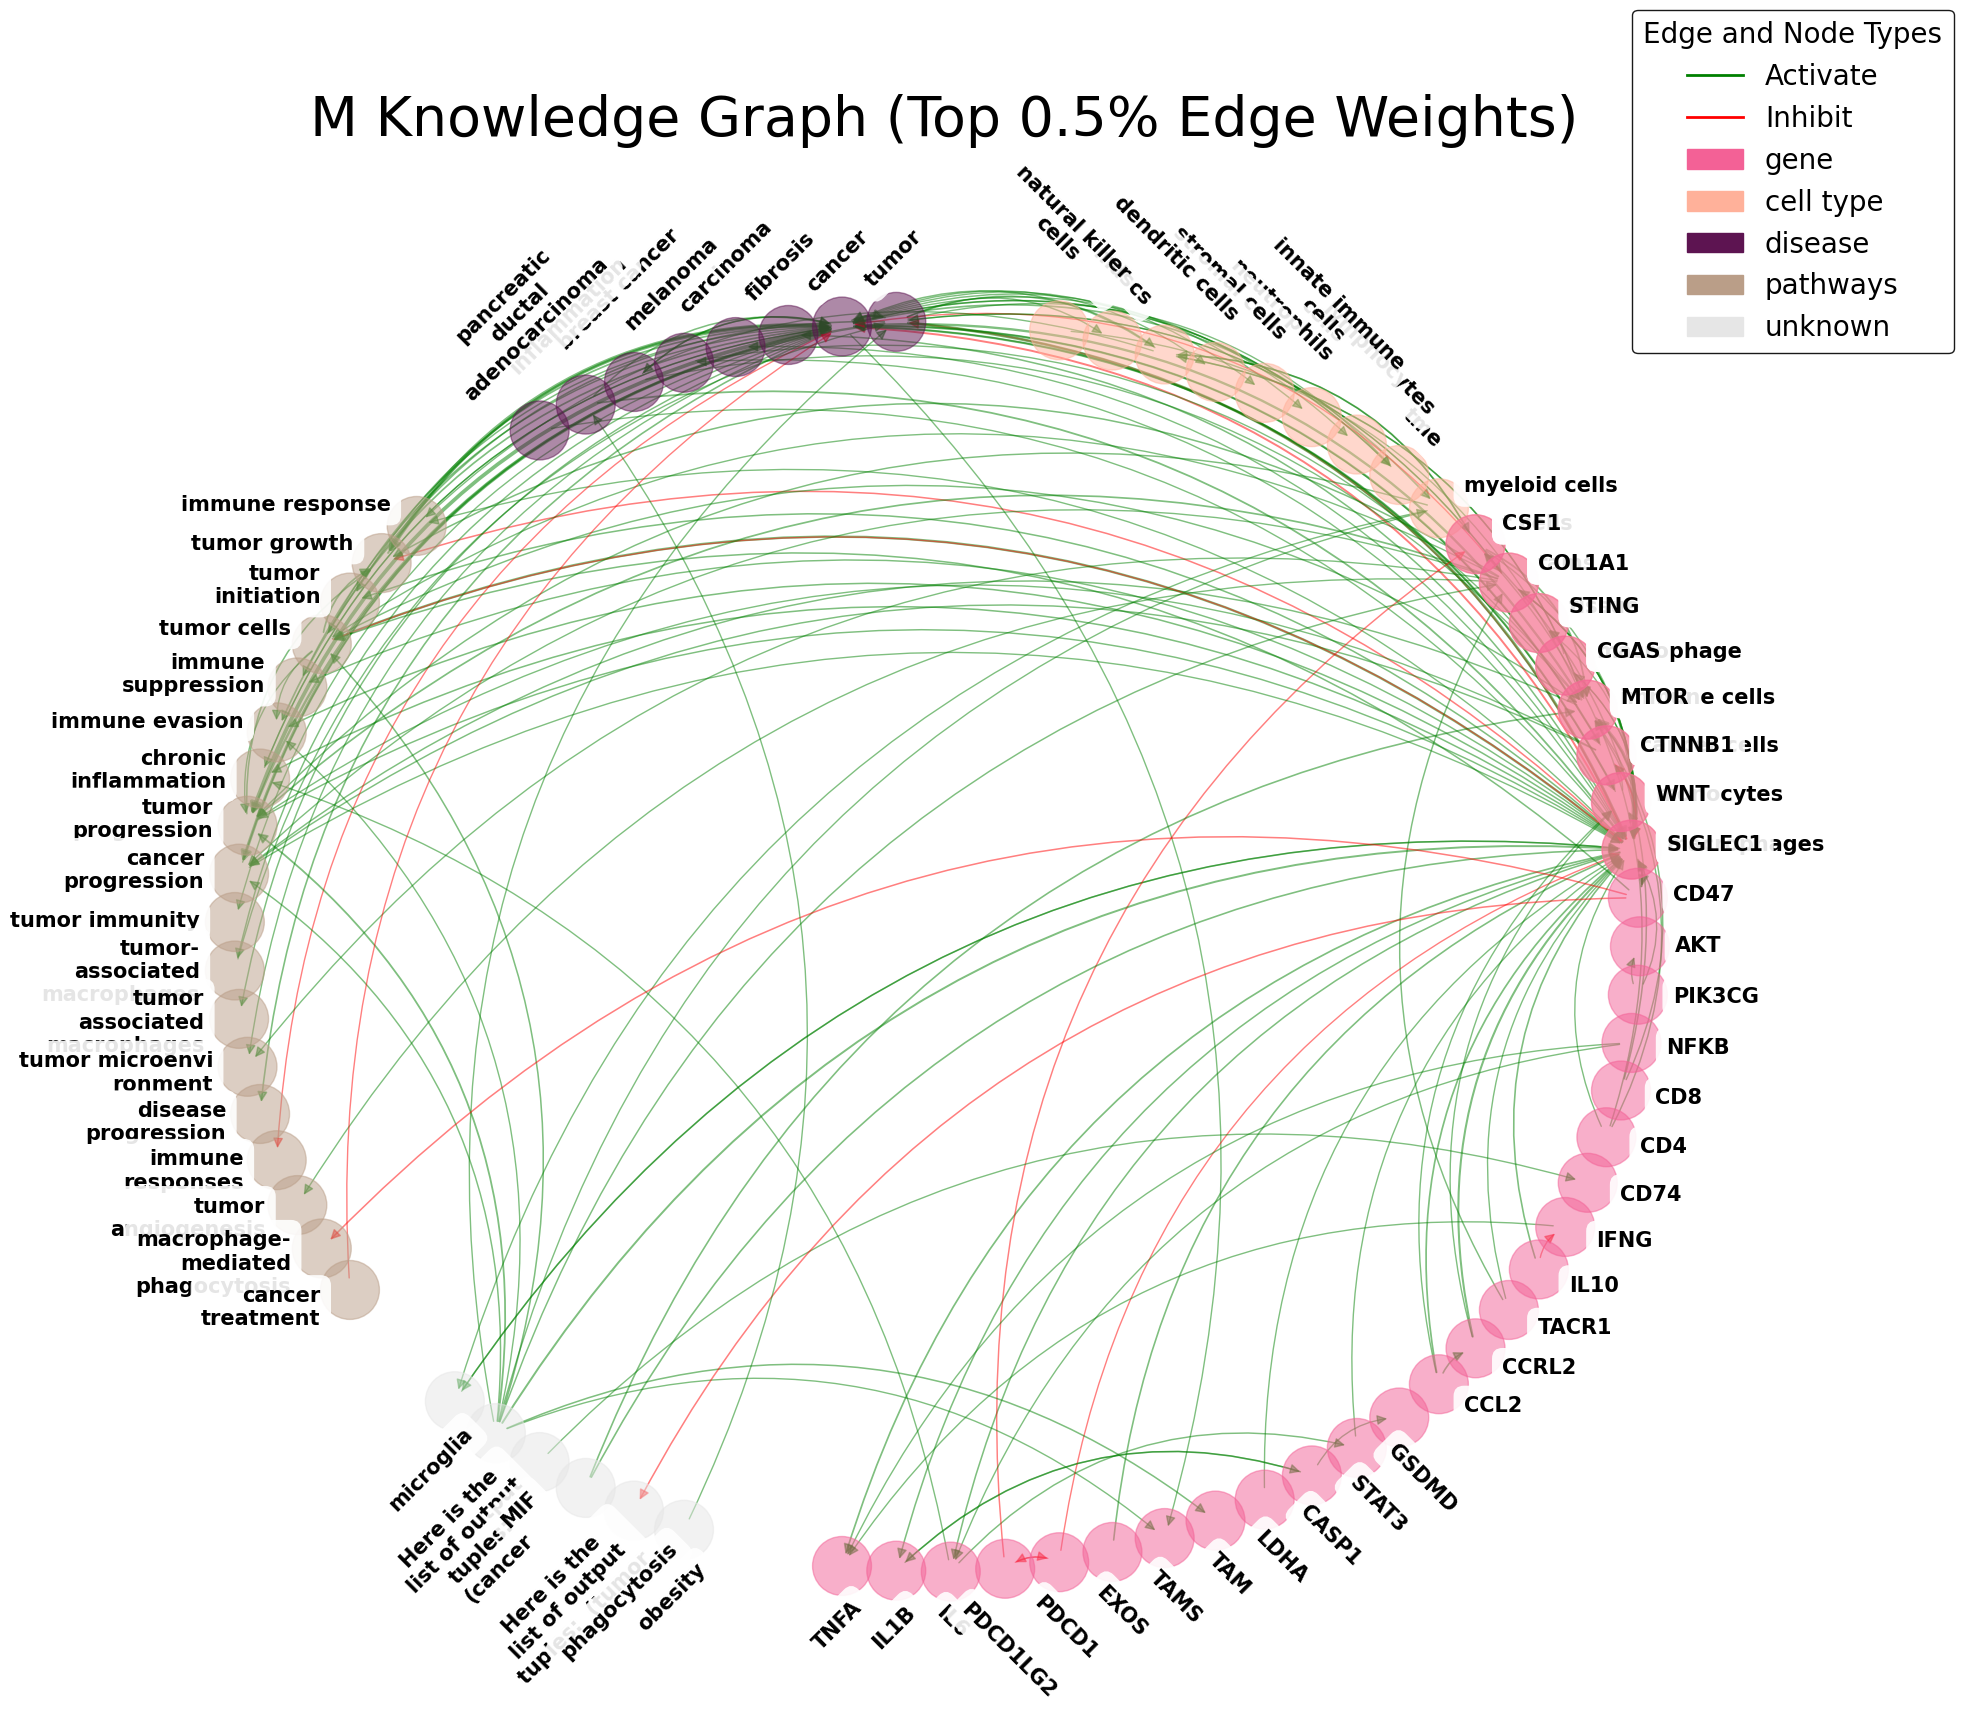

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import random
import textwrap
from collections import defaultdict
plt.rcParams['pdf.fonttype'] = 42

SEED = 129
random.seed(SEED)
np.random.seed(SEED)

def wrap_labels(text, width=15):  
    return textwrap.fill(text, width=width)

def get_text_alignment(angle):
    angle_deg = angle * 180 / np.pi
    if -45 <= angle_deg <= 45:  
        return 'left', 'center', 0
    elif 45 < angle_deg <= 135: 
        return 'center', 'bottom', -45 if angle_deg < 90 else 45  
    elif -135 <= angle_deg <= -45: 
        return 'center', 'top', 45 if angle_deg < -90 else -45  
    else:  # Left side
        return 'right', 'center', 0

def visualize_top_edges_circle(G, top_percent=1, save_path=None):
    weights = [d['weight'] for (u, v, d) in G.edges(data=True) if 'weight' in d]
    threshold = np.percentile(weights, 100 - top_percent)
    
    top_edges = [(u, v, d) for (u, v, d) in G.edges(data=True) if d.get('weight', 0) >= threshold]
    G_top = nx.DiGraph()
    G_top.add_edges_from(top_edges)
    
    plt.figure(figsize=(22,20))  
    nodes_by_type = defaultdict(list)
    for node in G_top.nodes():
        node_type = G.nodes[node].get('node_type', 'unknown')
        nodes_by_type[node_type].append(node)
    
    pos = {}
    total_nodes = len(G_top.nodes())
    current_angle = 0
    spacing_angle = 2 * np.pi / total_nodes
    group_spacing = spacing_angle * 2 
    
    for node_type, nodes in nodes_by_type.items():
        current_angle += group_spacing
        for node in nodes:
            angle = current_angle
            pos[node] = (3 * np.cos(angle), 3 * np.sin(angle))  # Increased radius to 3
            current_angle += spacing_angle
    pastel_colors = {'gene': '#F36196',      'cell type': '#FFB19A', 'disease': '#5D1451',    'pathways': '#BA9E88',  'unknown': '#E6E6E6'   }
    
    node_colors = [pastel_colors.get(G.nodes[node].get('node_type', 'unknown'), '#E6E6E6') 
                  for node in G_top.nodes()]
    
    nx.draw_networkx_nodes(G_top, pos, 
                          node_color=node_colors, 
                          node_size=1800, 
                          alpha=0.5)
    edge_weights = [d['weight'] for _, _, d in G_top.edges(data=True)]
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    normalized_weights = [(w - min_weight) / (max_weight - min_weight) for w in edge_weights]
    
    for (u, v, d), width in zip(G_top.edges(data=True), normalized_weights):
        color = 'green' if d['relationship'] == 'activate' else 'red'
        rad = 0.3 if abs(np.arctan2(pos[v][1] - pos[u][1], pos[v][0] - pos[u][0])) > np.pi/2 else -0.3
        
        nx.draw_networkx_edges(G_top, pos,
                             edgelist=[(u, v)],
                             edge_color=color,
                             width=1 + 2 * width, 
                             alpha=0.5,
                             arrowsize=15,
                             connectionstyle=f"arc3,rad={rad}")

    for node, (x, y) in pos.items():
        angle = np.arctan2(y, x)
        label_dist = 1.05 if abs(angle) < np.pi/3 else 1.05  
        label_pos = (x * label_dist, y * label_dist)      
        ha, va, rotation = get_text_alignment(angle)
        plt.annotate(wrap_labels(str(node)),
                    xy=(x, y),
                    xytext=label_pos,
                    textcoords='data',
                    ha=ha, va=va,
                    rotation=rotation,
                    bbox=dict(boxstyle='round,pad=0.5',
                            fc='white',
                            ec='none',
                            alpha=0.9),
                    fontsize=15, 
                    fontweight='bold')
    plt.title(f"{name} Knowledge Graph (Top {top_percent}% Edge Weights)", 
             fontsize=40, pad=10)
    edge_legend = [Line2D([0], [0], color=c, lw=2, label=l) 
                  for c, l in [('green', 'Activate'), ('red', 'Inhibit')]]
    node_legend = [mpatches.Patch(color=c, label=t) 
                  for t, c in pastel_colors.items()]
    plt.legend(handles=edge_legend + node_legend,
              loc='upper right',  
              bbox_to_anchor=(1.1, 1.1),  
              fontsize=20,
              title='Edge and Node Types',
              title_fontsize=20,
              framealpha=0.9,       
              edgecolor='black',   
              facecolor='white') 
    
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

# Main execution
top_percent = 0.5
visualize_top_edges_circle(weighted_network, 
                         top_percent=top_percent, 
                         save_path=f'/Volumes/she4/knowledgegraph/result/KG_{name}_circle_top{top_percent}.pdf')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import networkx as nx
plt.rcParams['pdf.fonttype'] = 42

cell_types = [
    "t cells", "regulatory t cells", "b cells", "nk cells", "macrophages",
    "dendritic cells", "epithelial cells", "fibroblasts", 
    "endothelial cells", "mast cells", "neutrophils", "myeloid cells"
]

cell_type_labels = {
    "t cells": "T Cells",
    "regulatory t cells": "Regulatory T Cells",
    "b cells": "B Cells",
    "nk cells": "NK Cells",
    "macrophages": "Macrophages",
    "dendritic cells": "Dendritic Cells",
    "epithelial cells": "Epithelial Cells",
    "fibroblasts": "Fibroblasts",
    "endothelial cells": "Endothelial Cells",
    "mast cells": "Mast Cells",
    "neutrophils": "Neutrophils",
    "myeloid cells": "Myeloid Cells"
}

tcga_cancer_types = [
    "bladder cancer", "breast cancer", "cervical cancer", "colon cancer",
    "lymphoma", "esophageal cancer", "glioblastoma", 
    "renal cell carcinoma", "acute myeloid leukemia", "liver cancer",
    "lung cancer", "ovarian cancer", "pancreatic cancer",
    "prostate cancer", "melanoma"
]

cancer_type_labels = {
    "bladder cancer": "Bladder",
    "breast cancer": "Breast",
    "cervical cancer": "Cervical",
    "colon cancer": "Colorectal",
    "lymphoma": "Lymphoma",
    "esophageal cancer": "Esophageal",
    "glioblastoma": "Glioblastoma",
    "renal cell carcinoma": "Kidney",
    "acute myeloid leukemia": "AML",
    "liver cancer": "Liver",
    "lung cancer": "Lung",
    "ovarian cancer": "Ovarian",
    "pancreatic cancer": "Pancreatic",
    "prostate cancer": "Prostate",
    "melanoma": "Melanoma",
}

def create_custom_colormap():
    colors = ['#313695', '#4575b4', '#74add1', '#abd9e9',
              '#fee090', '#f46d43', '#d73027', '#a50026']
    positions = [0, 0.1, 0.15, 0.25, 0.4, 0.6, 0.8, 1.0]
    return LinearSegmentedColormap.from_list('custom_diverging', 
                                           list(zip(positions, colors)))

def calculate_pvalues(G, node, true_scores, gene_nodes, n_permutations=1000):
    print(f"Calculating p-values for {node}...")
    true_gene_scores = {gene: true_scores[gene] for gene in gene_nodes}
    null_distributions = {gene: [] for gene in gene_nodes}
    personalization = {n: 1.0 if n == node else 0.0 for n in G.nodes()}
    for _ in tqdm(range(n_permutations)):
        shuffled_G = G.copy()
        weights = list(nx.get_edge_attributes(G, 'weight').values())
        np.random.shuffle(weights)
        for (u, v), w in zip(G.edges(), weights):
            shuffled_G[u][v]['weight'] = w
        perm_scores = nx.pagerank(shuffled_G, weight='weight', personalization=personalization)
        for gene in gene_nodes:
            null_distributions[gene].append(perm_scores[gene])
    pvalues = {}
    for gene in gene_nodes:
        null_dist = np.array(null_distributions[gene])
        pvalues[gene] = (null_dist >= true_gene_scores[gene]).mean()
    return pvalues

def analyze_nodes(G, node_list, node_labels, n_permutations=1000, pvalue_threshold=0.05):
    gene_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'gene']
    print(f"Found {len(gene_nodes)} gene nodes")
    node_gene_associations = {}
    for node in node_list:
        if node in G.nodes():
            print(f"\nAnalyzing {node}...")
            personalization = {n: 1.0 if n == node else 0.0 for n in G.nodes()}
            pagerank_scores = nx.pagerank(G, weight='weight', personalization=personalization)
            pvalues = calculate_pvalues(G, node, pagerank_scores, gene_nodes, n_permutations)
            significant_genes = [(gene, pagerank_scores[gene], pvalues[gene]) 
                               for gene in gene_nodes if pvalues[gene] < pvalue_threshold]
            significant_genes.sort(key=lambda x: x[1], reverse=True)
            node_gene_associations[node] = significant_genes
    return node_gene_associations

def plot_combined_analysis(cancer_associations, cell_associations, pvalue_threshold=0.05):
    fig = plt.figure(figsize=(30, 12))
    
    gs = GridSpec(1, 3, width_ratios=[1, 1, 1.2])
    ax1 = plt.subplot(gs[0])
    cell_counts = {cell_type_labels[cell]: len(genes) 
                  for cell, genes in cell_associations.items()}
    cell_df = pd.DataFrame.from_dict(cell_counts, orient='index', columns=['count'])
    cell_df = cell_df.sort_values('count', ascending=True)
    
    colors1 = sns.color_palette("muted", n_colors=len(cell_df))
    bars1 = ax1.barh(np.arange(len(cell_df)), cell_df['count'],
                    alpha=0.7, color=colors1)
    
    ax1.set_yticks(np.arange(len(cell_df)))
    ax1.set_yticklabels(cell_df.index)
    for i, v in enumerate(cell_df['count']):
        ax1.text(v + 0.5, i, str(v), va='center', fontsize=10, fontweight='bold')
    
    ax1.set_xlabel('Number of Significant Genes', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Cell Type', fontsize=16, fontweight='bold')
    ax1.set_title(f'Cell Type-Specific Gene Associations\n(p < {pvalue_threshold})', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    ax2 = plt.subplot(gs[1])
    cancer_counts = {cancer_type_labels[cancer]: len(genes) 
                    for cancer, genes in cancer_associations.items()}
    cancer_df = pd.DataFrame.from_dict(cancer_counts, orient='index', columns=['count'])
    cancer_df = cancer_df.sort_values('count', ascending=True)
    
    colors2 = sns.color_palette("muted", n_colors=len(cancer_df))
    bars2 = ax2.barh(np.arange(len(cancer_df)), cancer_df['count'],
                    alpha=0.7, color=colors2)
    
    ax2.set_yticks(np.arange(len(cancer_df)))
    ax2.set_yticklabels(cancer_df.index)
    for i, v in enumerate(cancer_df['count']):
        ax2.text(v + 0.5, i, str(v), va='center', fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('Number of Significant Genes', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Cancer Type', fontsize=16, fontweight='bold')
    ax2.set_title(f'Cancer-Specific Gene Associations\n(p < {pvalue_threshold})', 
                 fontsize=14, fontweight='bold', pad=20)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    ax3 = plt.subplot(gs[2])
    
    all_nodes = list(cell_associations.keys()) + list(cancer_associations.keys())
    all_labels = [cell_type_labels.get(n, cancer_type_labels.get(n)) for n in all_nodes]
    corr_matrix = np.zeros((len(all_nodes), len(all_nodes)))
    for i, n1 in enumerate(all_nodes):
        for j, n2 in enumerate(all_nodes):
            genes1 = set(gene for gene, _, _ in 
                        (cell_associations.get(n1, []) or cancer_associations.get(n1, [])))
            genes2 = set(gene for gene, _, _ in 
                        (cell_associations.get(n2, []) or cancer_associations.get(n2, [])))
            union_len = len(genes1.union(genes2))
            if union_len > 0:
                corr_matrix[i, j] = len(genes1.intersection(genes2)) / union_len
    
    custom_cmap = create_custom_colormap()
    
    sns.heatmap(
        corr_matrix,
        xticklabels=all_labels,
        yticklabels=all_labels,
        cmap=custom_cmap,
        ax=ax3,
        square=True,
        cbar_kws={
            'label': 'Gene Overlap\n(Jaccard Similarity)',
            'ticks': [0, 0.25, 0.5, 0.75, 1.0]
        }
    )
    
    cbar = ax3.collections[0].colorbar
    cbar.ax.axhline(y=0.25, color='black', linewidth=0.5)
    
    ax3.set_title('Cell Type and Cancer Similarity\nBased on Shared Significant Genes', 
                 fontsize=14, fontweight='bold', pad=20)
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax3.get_yticklabels(), rotation=0)
    
    fig.suptitle('Gene Association Analysis Across Cell Types and Cancers', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig

n_permutations = 100  
pvalue_threshold = 0.05
cancer_associations = analyze_nodes(weighted_network, tcga_cancer_types, 
                                 cancer_type_labels, n_permutations, pvalue_threshold)
cell_associations = analyze_nodes(weighted_network, cell_types, 
                               cell_type_labels, n_permutations, pvalue_threshold)
fig = plot_combined_analysis(cancer_associations, cell_associations, pvalue_threshold)
plt.savefig(f'/Volumes/she4/knowledgegraph/result/KG_{name}_info.pdf', 
            bbox_inches='tight', dpi=300,show=False)


### Output the KG to neo4j format (remember to change file names)

In [ ]:
## Export the network into a format that is compatible with neo4j
import os
import csv

def export_for_neo4j(G, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, 'M_nodes_pmid_gene_normalized.csv'), 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['nodeId:ID', 'name', 'node_type', ':LABEL'])
        for node, data in G.nodes(data=True):
            writer.writerow([node, node, data.get('node_type', ''), 'Term'])
    with open(os.path.join(output_folder, 'M_relationships_pmid_gene_normalized.csv'), 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([':START_ID', ':END_ID', 'relationship', 'weight:int', 'file_count:int', 'sources', ':TYPE'])
        for u, v, data in G.edges(data=True):
            sources_str = str(data.get('sources', []))
            writer.writerow([u, v, data['relationship'], data['weight'], data['file_count'], sources_str, 'INTERACTS'])
    print(f"Network exported for Neo4j in {output_folder}")

output_folder = '/Volumes/she4/knowledgegraph/result/neo4j_normalized'  # Change this to your desired output folder
export_for_neo4j(weighted_network, output_folder)

# Gene set annotations

In [46]:
import pandas as pd
def process_excel(file_path):
    xl = pd.ExcelFile(file_path)
    gene_sets = {}
    for sheet_name in xl.sheet_names:
        df = xl.parse(sheet_name)
        for column in df.columns:
            gene_set_name = f"{sheet_name}_{column}"
            genes = df[column].dropna().tolist()
            gene_sets[gene_set_name] = genes
    return gene_sets

file_path = '/Volumes/she4/knowledgegraph/data/validation/tirosh_MPs.xlsx'
result = process_excel(file_path)

In [ ]:
df = pd.read_excel('/Volumes/she4/knowledgegraph/data/validation/tirosh_MPs.xlsx', sheet_name=7)  

lung_hanada = df.iloc[:, 0].dropna().tolist()
pdac_meng = df.iloc[:, 1].dropna().tolist()
lung_carauhi = df.iloc[:, 2].dropna().tolist()
lowery = df.iloc[:, 3].dropna().tolist()
tcr_signature = {"lung_tcr1":lung_hanada,
                 "pdac_tcr": pdac_meng,
                 "lung_tcr2": lung_carauhi,
                 "pancancer_tcr": lowery}

df = pd.read_excel('/Volumes/she4/knowledgegraph/data/validation/tirosh_MPs.xlsx', sheet_name=8)  

NK_cytotoxicity = df.iloc[:, 0].dropna().tolist()
NK_inhibitory = df.iloc[:, 1].dropna().tolist()
NK_stimulatory = df.iloc[:, 2].dropna().tolist()
NK_TaNK = df.iloc[:, 3].dropna().tolist()
nk_signature = {"NK_cytotoxicity":NK_cytotoxicity,
                 "NK_inhibitory": NK_inhibitory,
                 "NK_TaNK": NK_TaNK}


In [ ]:
import networkx as nx
from collections import Counter
import random
import numpy as np
from scipy import stats

def weighted_choice(choices):
    total = sum(w for c, w in choices)
    r = random.uniform(0, total)
    upto = 0
    for c, w in choices:
        if upto + w >= r:
            return c
        upto += w
    assert False, "Shouldn't get here"

def adjusted_random_walk(G, start_nodes, n_walks=100, walk_length=10, jump_prob=0.1):
    visited = Counter()
    for start_node in start_nodes:
        if start_node not in G:
            print(f"Warning: {start_node} not found in the graph.")
            continue
        for _ in range(n_walks):
            current_node = start_node
            for _ in range(walk_length):
                visited[current_node] += 1
                if random.random() < jump_prob:
                    current_node = random.choice(list(G.nodes()))
                else:
                    activate_successors = [
                        (node, G[current_node][node].get('weight', 1))
                        for node in G.successors(current_node)
                        if G[current_node][node].get('relationship') == 'activate'
                    ]
                    activate_predecessors = [
                        (node, G[node][current_node].get('weight', 1))
                        for node in G.predecessors(current_node)
                        if G[node][current_node].get('relationship') == 'activate'
                    ]
                    neighbors = activate_successors + activate_predecessors
                    if not neighbors:
                        break
                    current_node = weighted_choice(neighbors)
    return visited

def permutation_test(G, gene_set, n_permutations=1000, n_walks=100, walk_length=10, jump_prob=0.1):
    real_visits = adjusted_random_walk(G, gene_set, n_walks, walk_length, jump_prob)
    pathway_nodes = [node for node in G.nodes() if G.nodes[node].get('node_type') in ['pathways']]
    
    permutation_results = []
    for _ in range(n_permutations):
        random_start = random.sample(list(G.nodes()), len(gene_set))
        perm_visits = adjusted_random_walk(G, random_start, n_walks, walk_length, jump_prob)
        permutation_results.append([perm_visits[node] for node in pathway_nodes])
    
    permutation_results = np.array(permutation_results)
    real_results = np.array([real_visits[node] for node in pathway_nodes])
    
    real_results = real_results.reshape(1, -1)
    
    p_values = ((permutation_results >= real_results).sum(axis=0) + 1) / (n_permutations + 1)
    ci_lower = np.percentile(permutation_results, 2.5, axis=0)
    ci_upper = np.percentile(permutation_results, 97.5, axis=0)
    
    return list(zip(pathway_nodes, real_results[0], p_values, ci_lower, ci_upper))

def find_top_pathway_nodes(G, gene_set, n_permutations=1000, n_walks=100, walk_length=10, jump_prob=0.1):
    results = permutation_test(G, gene_set, n_permutations, n_walks, walk_length, jump_prob)
    significant_results = [result for result in results if result[2] < 0.05]
    return sorted(significant_results, key=lambda x: x[1], reverse=True)

def create_activate_only_graph(G):
    activate_G = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        if data.get('relationship') == 'activate':
            activate_G.add_edge(u, v, weight=data.get('weight', 1))
    return activate_G

def pagerank_permutation_test(G, gene_set, n_permutations=1000, alpha=0.85):
    activate_G = create_activate_only_graph(G)
    valid_gene_set = [gene for gene in gene_set if gene in activate_G]
    
    if not valid_gene_set:
        print("Warning: None of the genes in gene_set are present in the activate-only graph.")
        return []

    real_personalization = {node: 1 if node in valid_gene_set else 0 for node in activate_G.nodes()}
    real_pagerank = nx.pagerank(activate_G, alpha=alpha, personalization=real_personalization, weight='weight')

    pathway_nodes = [node for node in G.nodes() if G.nodes[node].get('node_type') in ['pathways']]
    
    permutation_results = []
    for _ in range(n_permutations):
        random_gene_set = random.sample(list(activate_G.nodes()), min(len(valid_gene_set), len(activate_G)))
        perm_personalization = {node: 1 if node in random_gene_set else 0 for node in activate_G.nodes()}
        perm_pagerank = nx.pagerank(activate_G, alpha=alpha, personalization=perm_personalization, weight='weight')
        permutation_results.append([perm_pagerank.get(node, 0) for node in pathway_nodes])
    
    permutation_results = np.array(permutation_results)
    real_results = np.array([real_pagerank.get(node, 0) for node in pathway_nodes])
    
    permutation_results = permutation_results.T  
    real_results = real_results.reshape(-1, 1) 
    
    p_values = ((permutation_results >= real_results).sum(axis=1) + 1) / (n_permutations + 1)
    ci_lower = np.percentile(permutation_results, 2.5, axis=1)
    ci_upper = np.percentile(permutation_results, 97.5, axis=1)
    
    return list(zip(pathway_nodes, real_results.flatten(), p_values, ci_lower, ci_upper))


def find_top_pathways_pagerank(G, gene_set, n_permutations=1000, alpha=0.85):
    results = pagerank_permutation_test(G, gene_set, n_permutations, alpha)
    if not results:
        print("No valid results from PageRank analysis.")
        return []
    significant_results = [result for result in results if result[2] < 0.05]
    return sorted(significant_results, key=lambda x: x[1], reverse=True)

In [ ]:
for gs in ['Macrophages_Lipid-associated', 'Macrophages_Monocyte_Secreted', 'Macrophages_Cell-cycle', 'Macrophages_Interferon', 
           'Macrophages_MES_Glycolysis', 'Macrophages_MAC1', 'Macrophages_Stress_HSP', 'Macrophages_MAC2', 
           'Macrophages_Proteasomal-degradation', 'Macrophages_MAC3', 'Macrophages_MYC_Mitochondria',
             'Macrophages_Unfolded-protein-response', 'Macrophages_Respiration']:
    
    file_path = '/Volumes/she4/knowledgegraph/data/validation/tirosh_MPs.xlsx'
    result = process_excel(file_path)
    gene_set = result[gs]

    print("\n3. PageRank Analysis with Permutation Test")
    top_pathways_pr = find_top_pathways_pagerank(weighted_network, gene_set)
    print("Top pathways found using PageRank:")
    for result in top_pathways_pr:
        pathway, score, p_value, ci_lower, ci_upper = result
        print(f"{pathway}: score {score:.6f}, p-value: {p_value:.4f}, 95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")

    csv_data = [["Pathway", "Score", "P-value", "CI_Lower", "CI_Upper"]]
    for result in top_pathways_pr:
        pathway, score, p_value, ci_lower, ci_upper = result
        csv_data.append([pathway, f"{score:.6f}", f"{p_value:.4f}", f"{ci_lower:.6f}", f"{ci_upper:.6f}"])
    csv_filename = f"/Volumes/she4/knowledgegraph/result/pagerank_analysis_results_{gs}.csv"
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerows(csv_data)
    print(f"Results have been saved to {csv_filename}")
